<a href="https://colab.research.google.com/github/sherly0401/desktop-tutorial/blob/main/resnet152_80_20_(1)_(4)_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from google.colab import drive

In [ ]:
# prompt: google drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Define the base directory where your dataset is located
base_dir = "/content/drive/MyDrive/Citra Daun Padi"  # Replace with your actual path

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# Load the entire dataset
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    seed=123,
    image_size=(224, 224),
    label_mode='categorical'
)

# Extract images and labels
images = []
labels = []
for img, lbl in full_ds:
    images.append(img)
    labels.append(lbl)

images = tf.concat(images, axis=0)
labels = tf.concat(labels, axis=0)

# Perform a stratified split
train_images, test_images, train_labels, test_labels = train_test_split(
    images.numpy(), labels.numpy(), test_size=0.2, random_state=123, stratify=labels.numpy()
)
# Convert back to TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32) # Changed val_images and val_labels to test_images and test_labels

Found 500 files belonging to 3 classes.


In [ ]:
# Get class names
class_names = sorted(os.listdir(base_dir))
print("Class Names:", class_names)
num_classes = len(class_names)
print("Number of Classes:", num_classes)

Class Names: ['blast', 'blight', 'tungro']
Number of Classes: 3


In [ ]:
from collections import Counter
# Count total images in the training and validation datasets
train_total = sum(batch.shape[0] for batch, _ in train_ds)
test_total = sum(batch.shape[0] for batch, _ in test_ds)

print(f"Total images in training set: {train_total}")
print(f"Total images in testing set: {test_total}")

Total images in training set: 400
Total images in testing set: 100


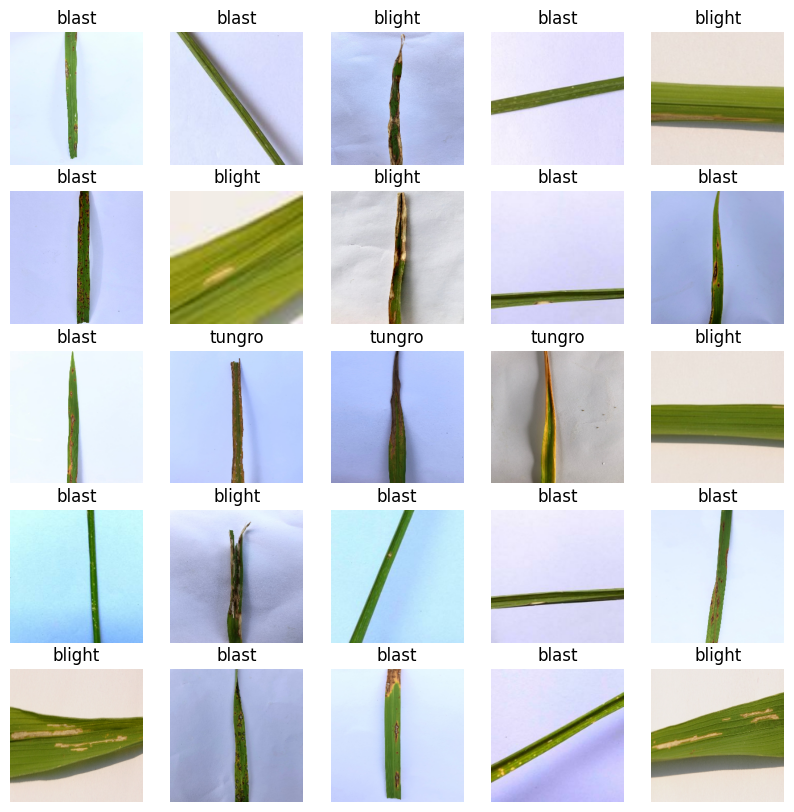

In [ ]:
# Function to display images
def show_images(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(25):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[np.argmax(labels[i])])
            plt.axis("off")
    plt.show()
    # Show sample images
show_images(train_ds, class_names)

In [ ]:
# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:

# Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),        # Flipping gambar secara horizontal
    tf.keras.layers.RandomRotation(0.2),             # Rotasi acak hingga 20% dari sudut 360 derajat
    tf.keras.layers.RandomZoom(0.1),                 # Zoom acak hingga 10%

])


In [ ]:
# Create the base model using ResNet152
base_model = tf.keras.applications.ResNet152(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Freeze the base model
base_model.trainable = False

# Create the model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)


In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
# Print model summary
base_model.summary()


Model: "resnet152"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 58,370,944 (222.67 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 58,370,944 (222.67 MB)

In [ ]:
early_stopping = callbacks.EarlyStopping(patience=3)
# Train the model
history = model.fit(
    train_ds,
    epochs=25,
    validation_data=test_ds,
    callbacks=[early_stopping]
)


Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.3520 - loss: 1.5767 - val_accuracy: 0.3000 - val_loss: 1.2295
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.3884 - loss: 1.3981 - val_accuracy: 0.4400 - val_loss: 1.0519
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.4296 - loss: 1.2097 - val_accuracy: 0.5400 - val_loss: 0.9344
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5347 - loss: 1.0066 - val_accuracy: 0.6500 - val_loss: 0.8386
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5618 - loss: 0.9655 - val_accuracy: 0.7000 - val_loss: 0.7657
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5905 - loss: 0.9130 - val_accuracy: 0.7400 - val_loss: 0.6966
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6325 - loss: 0.8686 - val_accuracy: 0.8000 - val_loss: 0.6419
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6397 - loss: 0.8289 - val_accuracy: 0.8300 - val_loss:

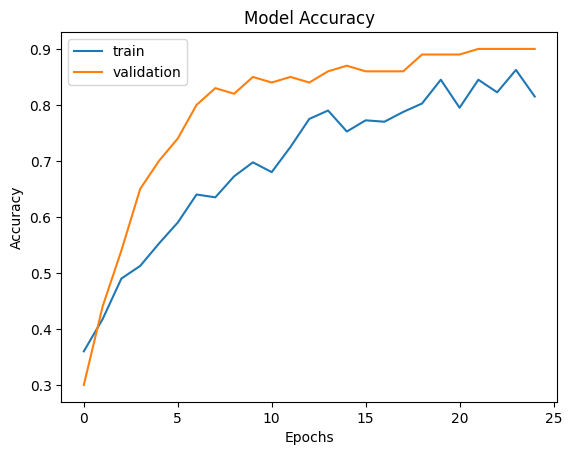

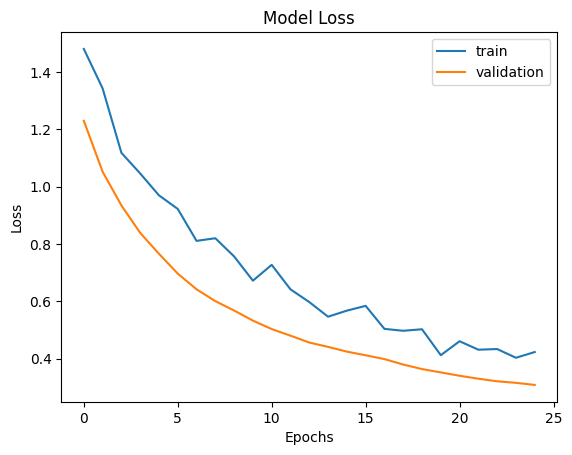

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([np.argmax(y, axis=1) for x, y in test_ds], axis=0)

# Calculate and print accuracy
accuracy = np.mean(y_pred_classes == y_true)
# Evaluate the model to get loss and accuracy
score = model.evaluate(test_ds, verbose=0)

print("Test Accuracy : %0.02f %%" % (score[1]*100))
print("Test Loss : %0.02f %%" % (score[0]*100))

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
Test Accuracy : 90.00 %
Test Loss : 30.84 %


In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization


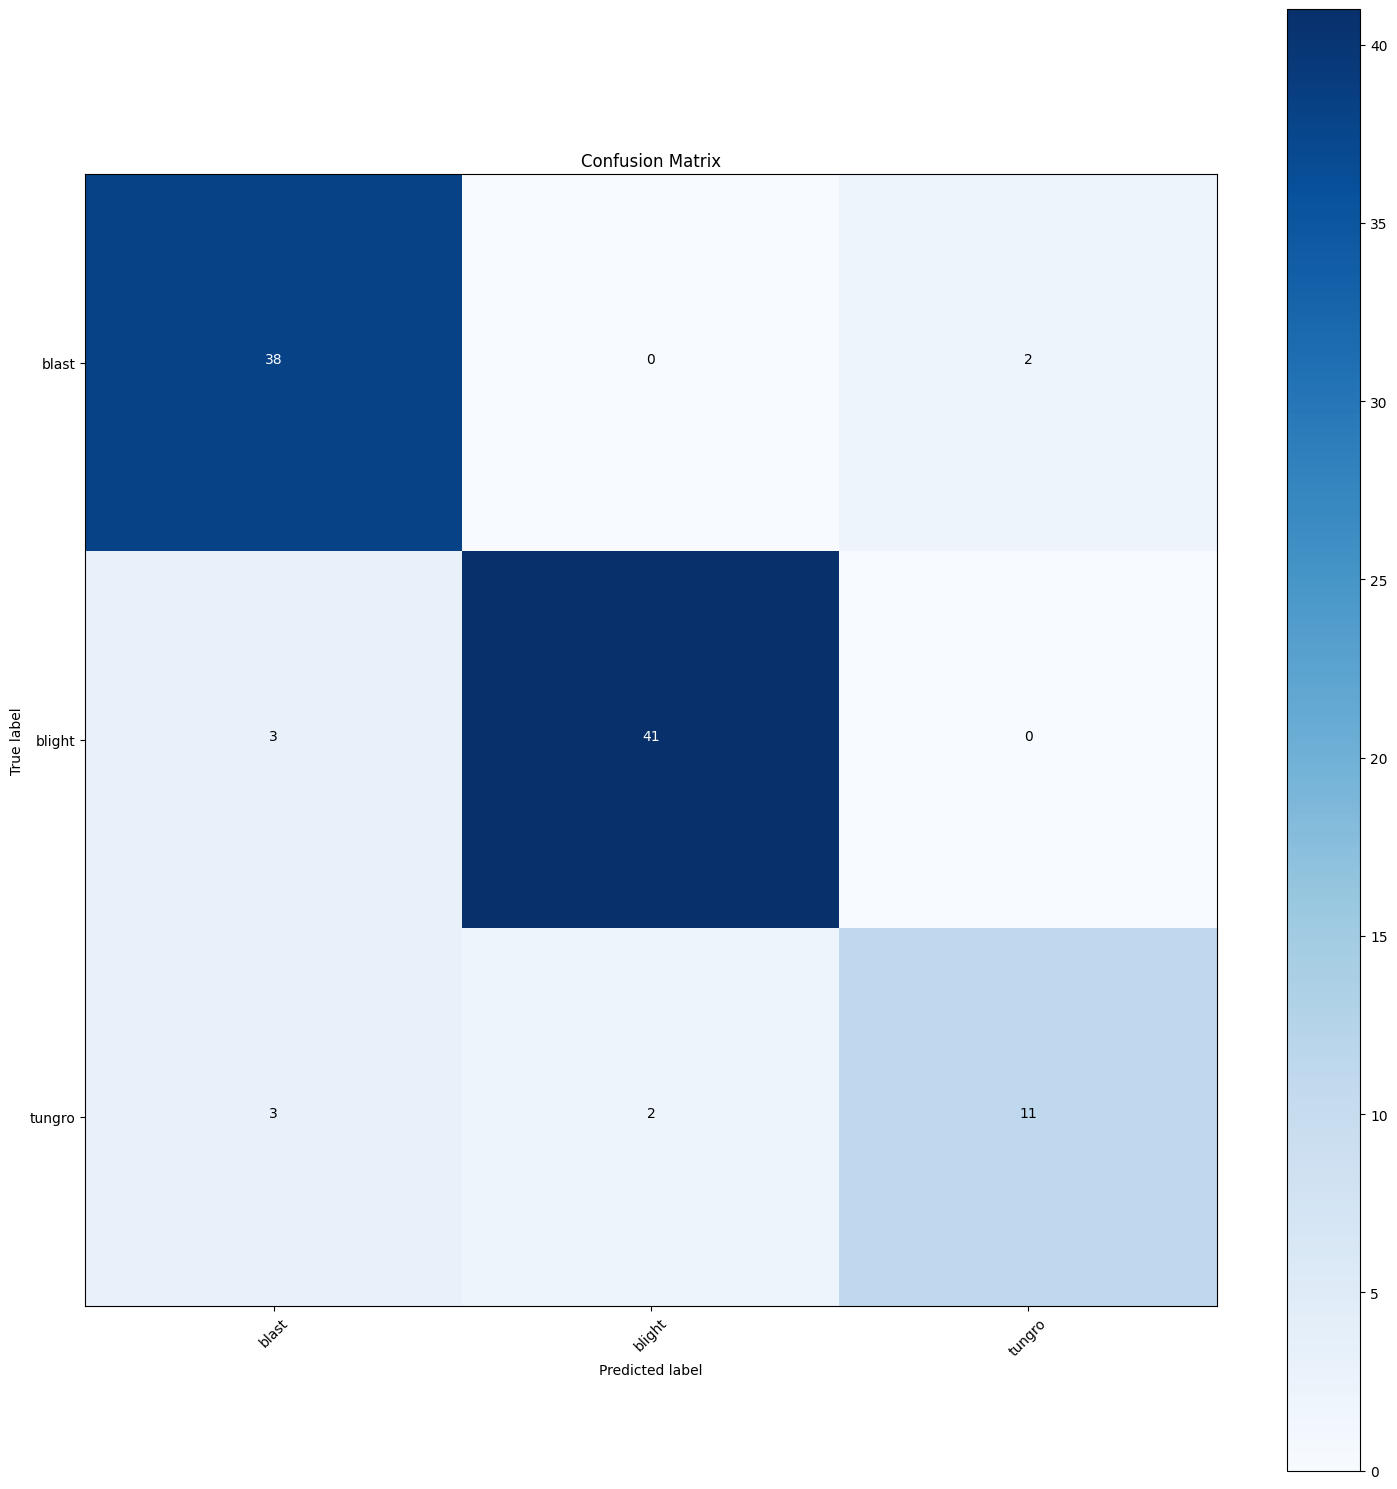

In [ ]:
# Generate and plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plot_confusion_matrix(cm, class_names, title='Confusion Matrix',normalize=False)


In [ ]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))



Classification Report:
              precision    recall  f1-score   support

       blast       0.86      0.95      0.90        40
      blight       0.95      0.93      0.94        44
      tungro       0.85      0.69      0.76        16

    accuracy                           0.90       100
   macro avg       0.89      0.86      0.87       100
weighted avg       0.90      0.90      0.90       100

